In [411]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [458]:
from pathlib import Path
import time
import numpy  as np
import nibabel as nib
import matplotlib.pyplot as plt
from midasmednet.dataset import LandmarkDataset, SegmentationDataset
from torch.utils.data import Dataset, DataLoader

## Segmentation Trainer (Aorta, one class segmentation, ZARR data storage)

In [413]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/data.zarr'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [100, 100, 100]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.1, 0.9]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from zarr file (customizable)
data_reader = midasmednet.dataset.read_zarr

ds = SegmentationDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', label_group='labels')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images_norm/100000
DEBUG:midasmednet.dataset:loading images_norm/100001
DEBUG:midasmednet.dataset:loading images_norm/100002
DEBUG:midasmednet.dataset:loading images_norm/100003
DEBUG:midasmednet.dataset:finished: 0.173 s, current memory usage  0.58GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading labels/100000
DEBUG:midasmednet.dataset:loading labels/100001
DEBUG:midasmednet.dataset:loading labels/100002
DEBUG:midasmednet.dataset:loading labels/100003
DEBUG:midasmednet.dataset:finished: 0.056 s, current memory usage  0.61GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.022 s


In [414]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

subject_key:     100000
selected_class:  1
position:        [97 47 48]
data shape:      (1, 100, 100, 100)
label shape:     (1, 100, 100, 100)


<IPython.core.display.Javascript object>


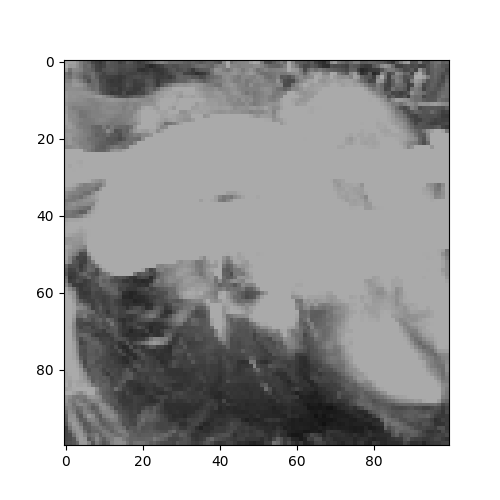

In [427]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray', vmin=0, vmax=3)

<IPython.core.display.Javascript object>


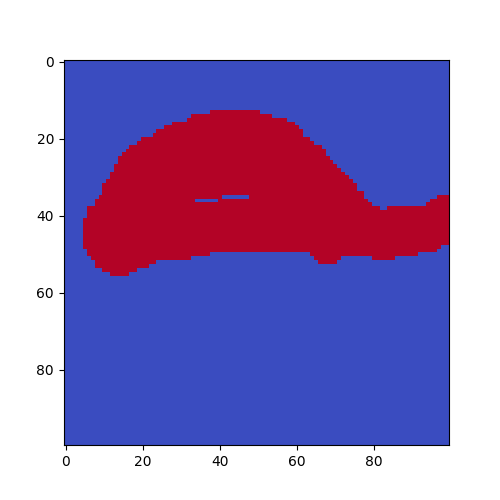

In [425]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][0,...], axis=2), cmap='coolwarm')

## Segmentation Trainer (CT organs, multi class segmentation, Nifti files)

In [450]:
data_path = '/mnt/share/raheppt1/data/metvol/interim/ctorgan/nifti/nifti_lowres'
subject_keys = ['023', '024', '025', '026']
patch_size = [100, 100, 100]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.5, 0.2, 0.3, 0.4]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from nifti files (customizable)
# dir structure: <data_path>/<image_group>/<subj_key>...nii...
data_reader = midasmednet.dataset.read_nifti
ds = SegmentationDataset(data_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images', label_group='labels')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images/023
DEBUG:midasmednet.dataset:loading images/024
DEBUG:midasmednet.dataset:loading images/025
DEBUG:midasmednet.dataset:loading images/026
DEBUG:midasmednet.dataset:finished: 4.851 s, current memory usage  0.82GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading labels/023
DEBUG:midasmednet.dataset:loading labels/024
DEBUG:midasmednet.dataset:loading labels/025
DEBUG:midasmednet.dataset:loading labels/026
DEBUG:midasmednet.dataset:finished: 0.594 s, current memory usage  0.90GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.121 s


In [454]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

subject_key:     023
selected_class:  3
position:        [115  27 149]
data shape:      (1, 100, 100, 100)
label shape:     (1, 100, 100, 100)


<IPython.core.display.Javascript object>


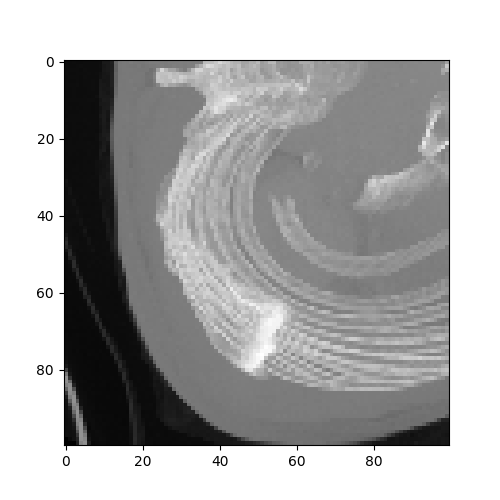

In [455]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray')

<IPython.core.display.Javascript object>


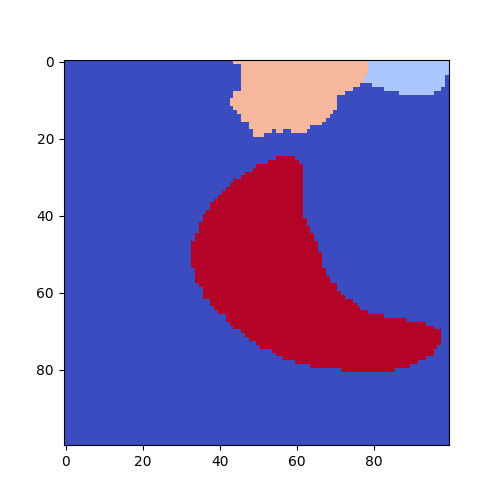

In [456]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][0,...], axis=2), cmap='coolwarm')

## Landmark Trainer (aorta, hdf5 dataset)

In [503]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/hdf5/data.h5'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [100, 100, 100]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from hdf file (customizable)
data_reader = midasmednet.dataset.read_h5

ds = LandmarkDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', heatmap_group='heatmaps')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images_norm/100000
DEBUG:midasmednet.dataset:loading images_norm/100001
DEBUG:midasmednet.dataset:loading images_norm/100002
DEBUG:midasmednet.dataset:loading images_norm/100003
DEBUG:midasmednet.dataset:finished: 0.275 s, current memory usage  2.38GB, peak memory usage 4.64GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading heatmaps/100000
DEBUG:midasmednet.dataset:loading heatmaps/100001
DEBUG:midasmednet.dataset:loading heatmaps/100002
DEBUG:midasmednet.dataset:loading heatmaps/100003
DEBUG:midasmednet.dataset:finished: 1.283 s, current memory usage  2.57GB, peak memory usage 4.64GB
DEBUG:midasmednet.dataset:generating class labels from heatmaps ...
DEBUG:midasmednet.dataset:finished  3.825 s
DEBUG:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.388 s


In [482]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

subject_key:     100000
selected_class:  5
position:        [90 51 44]
data shape:      (1, 100, 100, 100)
label shape:     (7, 100, 100, 100)


<IPython.core.display.Javascript object>


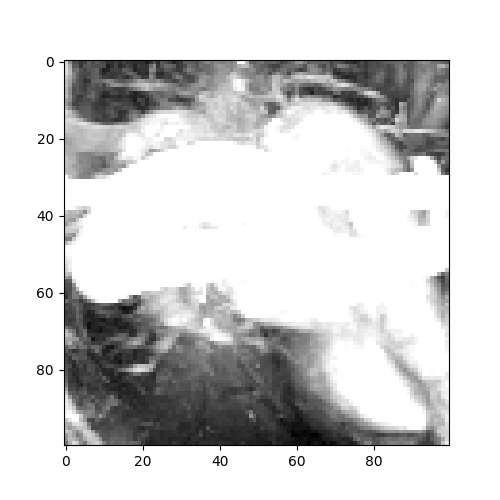

In [483]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray')

<IPython.core.display.Javascript object>


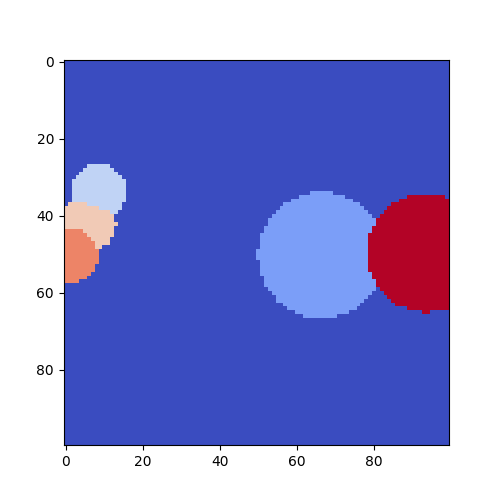

In [484]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][-1,...], axis=2), cmap='coolwarm')

<IPython.core.display.Javascript object>


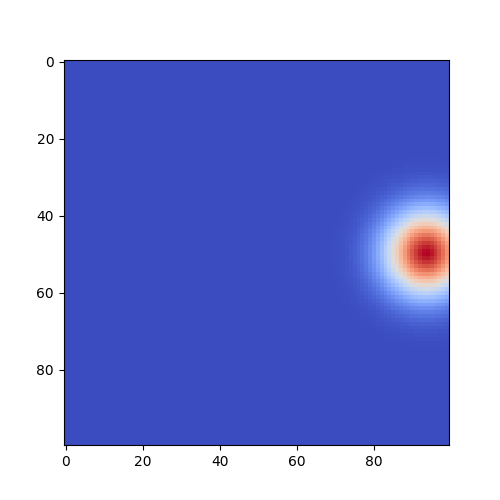

In [485]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][sample['selected_class']-1,...], axis=2), cmap='coolwarm')

## Example: Slice samling (aorta, hdf5 dataset)

In [502]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/hdf5/data.h5'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [100, 100, 1]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from hdf file (customizable)
data_reader = midasmednet.dataset.read_h5

ds = LandmarkDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', heatmap_group='heatmaps')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images_norm/100000
DEBUG:midasmednet.dataset:loading images_norm/100001
DEBUG:midasmednet.dataset:loading images_norm/100002
DEBUG:midasmednet.dataset:loading images_norm/100003
DEBUG:midasmednet.dataset:finished: 0.480 s, current memory usage  2.38GB, peak memory usage 4.64GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading heatmaps/100000
DEBUG:midasmednet.dataset:loading heatmaps/100001
DEBUG:midasmednet.dataset:loading heatmaps/100002
DEBUG:midasmednet.dataset:loading heatmaps/100003
DEBUG:midasmednet.dataset:finished: 1.377 s, current memory usage  2.57GB, peak memory usage 4.64GB
DEBUG:midasmednet.dataset:generating class labels from heatmaps ...
DEBUG:midasmednet.dataset:finished  3.154 s
DEBUG:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.280 s


subject_key:     100000
selected_class:  5
position:        [106  61  63]
data shape:      (1, 100, 100, 100)
label shape:     (7, 100, 100, 100)


<IPython.core.display.Javascript object>


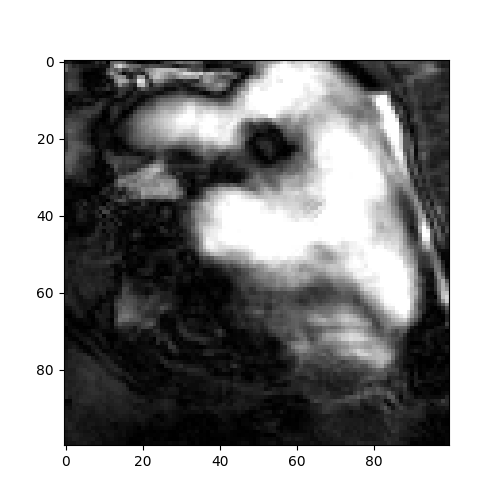

<IPython.core.display.Javascript object>


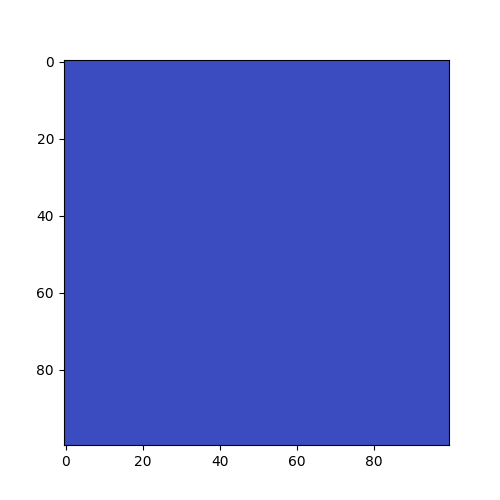

In [520]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

plt.figure(figsize=(5,5))
plt.imshow(sample['data'][0,:,:,0], cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(sample['label'][-1,:,:,0], cmap='coolwarm')
plt.show()